In [231]:
from scipy.stats import crystalball, norm, expon
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad



def g_s(X,beta,m,mu,sigma):
    pdf=crystalball(beta,m,loc=mu,scale=sigma)
    norm_factor = pdf.cdf(5)-pdf.cdf(0)
    trunc_pdf= pdf.pdf(X)/norm_factor
    return trunc_pdf


def h_s(Y,lam):
    pdf = expon(scale=1/lam)
    norm_factor = pdf.cdf(10)-pdf.cdf(0)
    trunc_pdf = pdf.pdf(Y)/norm_factor
    return trunc_pdf

def g_b(X):
    pdf=1/5*np.ones_like(X)
    return pdf

def h_b(Y,mu_b,sigma_b):
    pdf = norm(loc=mu_b,scale=sigma_b)
    norm_factor=pdf.cdf(10)-pdf.cdf(0)
    trunc_pdf = pdf.pdf(Y)/norm_factor  
    return trunc_pdf

def f_tot(X,Y,f,beta,m,mu,sigma,lam,mu_b,sigma_b):
    pdf = f*g_s(X,beta,m,mu,sigma)*h_s(Y,lam)+(1-f)*g_b(X)*h_b(Y,mu_b,sigma_b)
    return pdf






In [232]:
mu_true = 3
sigma_true = 0.3
beta_true= 1
m_true = 1.4
f_true =0.6
lam_true=0.3
mu_b_true =0
sigma_b_true = 2.5


g_s_integral, g_s_error = quad(lambda x: g_s(x, beta=beta_true, m=m_true, mu=mu_true, sigma=sigma_true), 0, 5)
h_s_integral, h_s_error = quad(lambda x: h_s(x, lam=lam_true), 0, 10)
g_b_integral, g_b_error = quad(g_b, 0, 5)  # Assuming g_b doesn't need extra parameters
h_b_integral, h_b_error = quad(lambda x: h_b(x, mu_b=mu_b_true, sigma_b=sigma_b_true), 0, 10)

x_min=0
x_max=5
y_min=0 
y_max=10
# Print the results
print(f"Integral of g_s(x) from {x_min} to {x_max}: {g_s_integral:.6f} (Error estimate: {g_s_error:.6e})")
print(f"Integral of h_s(y) from {y_min} to {y_max}: {h_s_integral:.6f} (Error estimate: {h_s_error:.6e})")
print(f"Integral of g_b(x) from {x_min} to {x_max}: {g_b_integral:.6f} (Error estimate: {g_b_error:.6e})")
print(f"Integral of h_b(y) from {y_min} to {y_max}: {h_b_integral:.6f} (Error estimate: {h_b_error:.6e})")

Integral of g_s(x) from 0 to 5: 1.000000 (Error estimate: 7.289797e-09)
Integral of h_s(y) from 0 to 10: 1.000000 (Error estimate: 1.110223e-14)
Integral of g_b(x) from 0 to 5: 1.000000 (Error estimate: 1.110223e-14)
Integral of h_b(y) from 0 to 10: 1.000000 (Error estimate: 4.839198e-12)


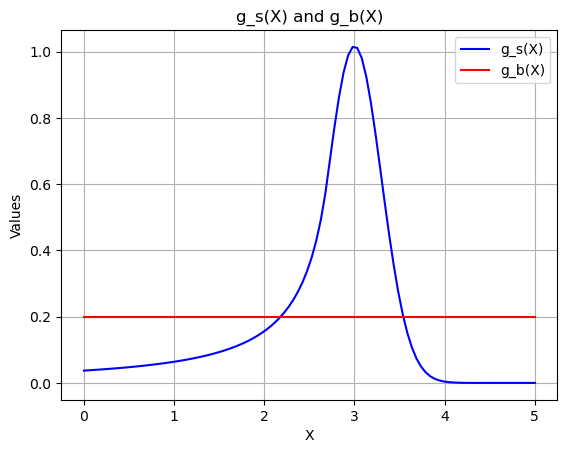

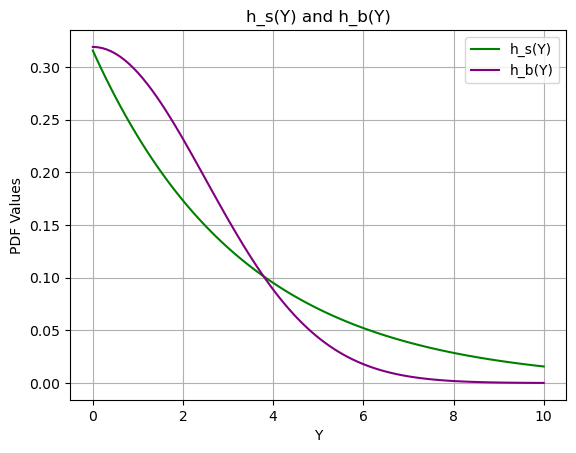

In [233]:



X=np.linspace(0,5,100)
Y=np.linspace(0,10,100)
plt.figure(1)  # First figure
plt.plot(X, g_s(X, beta=beta_true, m=m_true, mu=mu_true, sigma=sigma_true), label="g_s(X)", color='blue')
plt.plot(X, g_b(X), label="g_b(X)", color='red')
plt.title("g_s(X) and g_b(X)")
plt.xlabel("X")
plt.ylabel("Values")
plt.legend()
plt.grid(True)

# Create the second figure for h_s(Y) and h_b(Y)
plt.figure(2)  # Second figure
plt.plot(Y, h_s(Y, lam=lam_true), label="h_s(Y)", color='green')
plt.plot(Y, h_b(Y, mu_b=mu_b_true, sigma_b=sigma_b_true), label="h_b(Y)", color='purple')
plt.title("h_s(Y) and h_b(Y)")
plt.xlabel("Y")
plt.ylabel("PDF Values")
plt.legend()
plt.grid(True)

# Show both figures
plt.show()

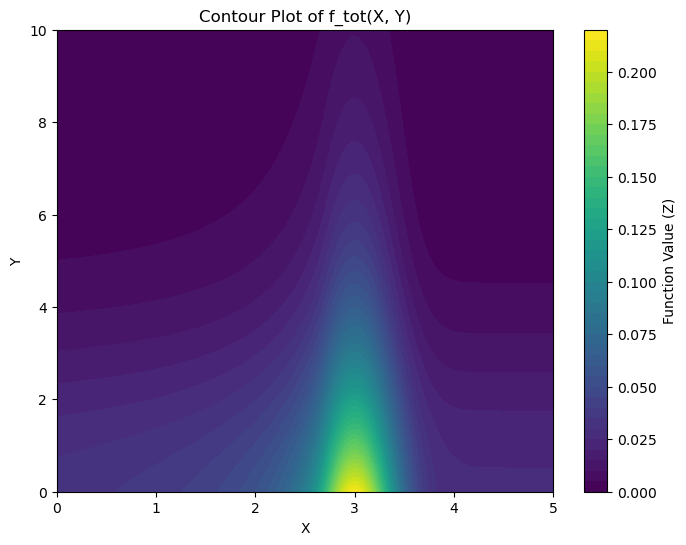

In [234]:


X, Y = np.meshgrid(X, Y)
Z = f_tot(X, Y, f=f_true, beta=beta_true, m=m_true, mu=mu_true, sigma=sigma_true, lam=lam_true, mu_b=mu_b_true, sigma_b=sigma_b_true)

# Alternatively, you can use a filled contour plot:
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Function Value (Z)')
plt.title("Contour Plot of f_tot(X, Y)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [192]:

# max_value = np.max(Z)

# def accept_reject(N):  #change to batch generation
#     accepted_points=[]
#     rejected_points=[]
#     with tqdm(total=N, desc="Sampling", unit="sample") as pbar:
#         while len(accepted_points)<N:
#             x=np.random.uniform(0, 5)
#             y=np.random.uniform(0, 10)
#             y_guess=np.random.uniform(0, max_value)
#             y_val=f_tot(x,y,f=f_true,beta=beta_true,m=m_true,mu=mu_true,sigma=sigma_true,lam=lam_true,mu_b=mu_b_true,sigma_b=sigma_b_true)
#             if y_guess<=y_val:
#                 accepted_points.append((x, y))
#                 pbar.update(1)  
#             #else:    
#                 #rejected_points.append((x, y)) 

        
#     return accepted_points


# sample = accept_reject(100000)


In [235]:
max_value = np.max(Z)
def faster_event_generation(N):
    accepted_points = []
    
    while len(accepted_points)<N:
        x_batch = np.random.uniform(0, 5, int(N/2))
        y_batch = np.random.uniform(0, 10, int(N/2))
        y_guess = np.random.uniform(0, max_value, int(N/2))
        y_val = f_tot(x_batch, y_batch, f=f_true, beta=beta_true, m=m_true, mu=mu_true, sigma=sigma_true, lam=lam_true, mu_b=mu_b_true, sigma_b=sigma_b_true)
        accepted_indices = y_guess <= y_val
        # Add accepted points to the list
        accepted_points.extend(zip(x_batch[accepted_indices], y_batch[accepted_indices]))
            
            
    accepted_points = np.array(accepted_points[:N])
    
    return accepted_points
    

sample = faster_event_generation(100000)   

        


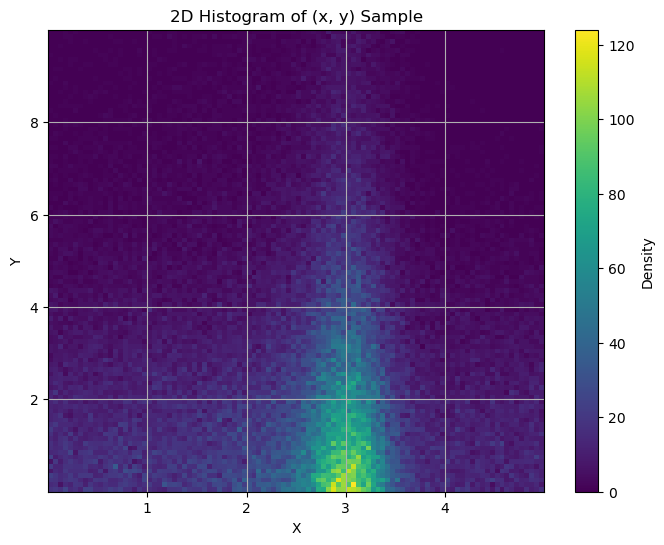

In [236]:
#saved_sample = np.array(sample)
x = sample[:, 0]
y = sample[:, 1]
plt.figure(figsize=(8, 6))
plt.hist2d(x, y, bins=100, cmap='viridis')

# Add a colorbar to show the number of points in each bin
plt.colorbar(label='Density')

plt.title("2D Histogram of (x, y) Sample")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

In [261]:
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL

def density(data,N,f,beta,m,mu,sigma,lam,mu_b,sigma_b):
    #X=data[:,0]
    #Y=data[:,1]
    X,Y =data
    return N, N*f_tot(X,Y,f,beta,m,mu,sigma,lam,mu_b,sigma_b)

nll = ExtendedUnbinnedNLL(sample.T, density)

mi = Minuit(nll , N=100000, f=0.6 ,beta=1 ,m=1.4 ,mu=3 ,sigma=0.3 ,lam=0.3 ,mu_b=0.0 ,sigma_b=2.5)

mi.migrad()

mi.hesse()

orig_fit_values = mi.values


print(*mi.values)



100000.20008139596 0.6012233404306375 1.011757942780292 1.371562314066366 2.9999173672447172 0.3002105275468589 0.3016501505846521 -0.11788970908350004 2.520241494375023


In [238]:
import timeit

def run_faster_event_generation():
    faster_event_generation(100000)

def run_normal_dist():
    np.random.normal(size=100000)

def run_fit():
    mi.migrad()

time_norm = timeit.timeit(run_normal_dist, number=100)
average_time_norm = time_norm / 100

time_gen = timeit.timeit(run_faster_event_generation, number=100)
average_time_gen = time_gen / 100
average_time_gen_rel=average_time_gen/average_time_norm

time_fit = timeit.timeit(run_fit, number=100)
average_time_fit = time_fit / 100
average_time_fit_rel=average_time_fit/average_time_norm



print(f"Average time for 100 runs of normal dist: {average_time_norm:.4f} seconds")
print(f"Average relative time for 100 runs of event generation: {average_time_gen_rel:.4f} ")
print(f"Average relative time for 100 runs of fitting: {average_time_fit_rel:.4f}")


Average time for 100 runs of normal dist: 0.0013 seconds
Average relative time for 100 runs of event generation: 109.7795 
Average relative time for 100 runs of fitting: 247.7516


In [239]:
from tqdm import tqdm 

def generate(N,f,beta,m,mu,sigma,lam,mu_b,sigma_b):
    accepted_points = []
    N=int(N)
    while len(accepted_points)<N:
        x_batch = np.random.uniform(0, 5, int(N/2))
        y_batch = np.random.uniform(0, 10, int(N/2))
        y_guess = np.random.uniform(0, max_value, int(N/2))
        y_val = f_tot(x_batch, y_batch, f, beta, m, mu, sigma, lam, mu_b, sigma_b)
        accepted_indices = y_guess <= y_val
        # Add accepted points to the list
        accepted_points.extend(zip(x_batch[accepted_indices], y_batch[accepted_indices]))
            
    accepted_points = np.array(accepted_points[:N])
    
    return accepted_points


def fit(dset,N,f,beta,m,mu,sigma,lam,mu_b,sigma_b):
    nll = ExtendedUnbinnedNLL(dset.T, density)
    mi = Minuit(nll , N, f ,beta ,m ,mu ,sigma ,lam ,mu_b ,sigma_b)
    mi.migrad ()
    mi.hesse ()
    return mi

def fit_toys(Ntoy,sample_size,f,beta,m,mu,sigma,lam,mu_b,sigma_b):
    values =[]
    errors = []
    Num=np.random.poisson(sample_size, Ntoy)
    toys = [ generate(Num[_],f,beta,m,mu,sigma,lam,mu_b,sigma_b) for _ in range(Ntoy) ]
    for toy in tqdm(toys):
        mi_t = fit(toy,sample_size,f,beta,m,mu,sigma,lam,mu_b,sigma_b)
        values.append( list(mi_t.values) )
        errors.append( list(mi_t.errors) )
    return values, errors




In [219]:
values ,errors = fit_toys(Ntoy,10000,*mi.values[1:])


100%|██████████| 250/250 [02:15<00:00,  1.85it/s]


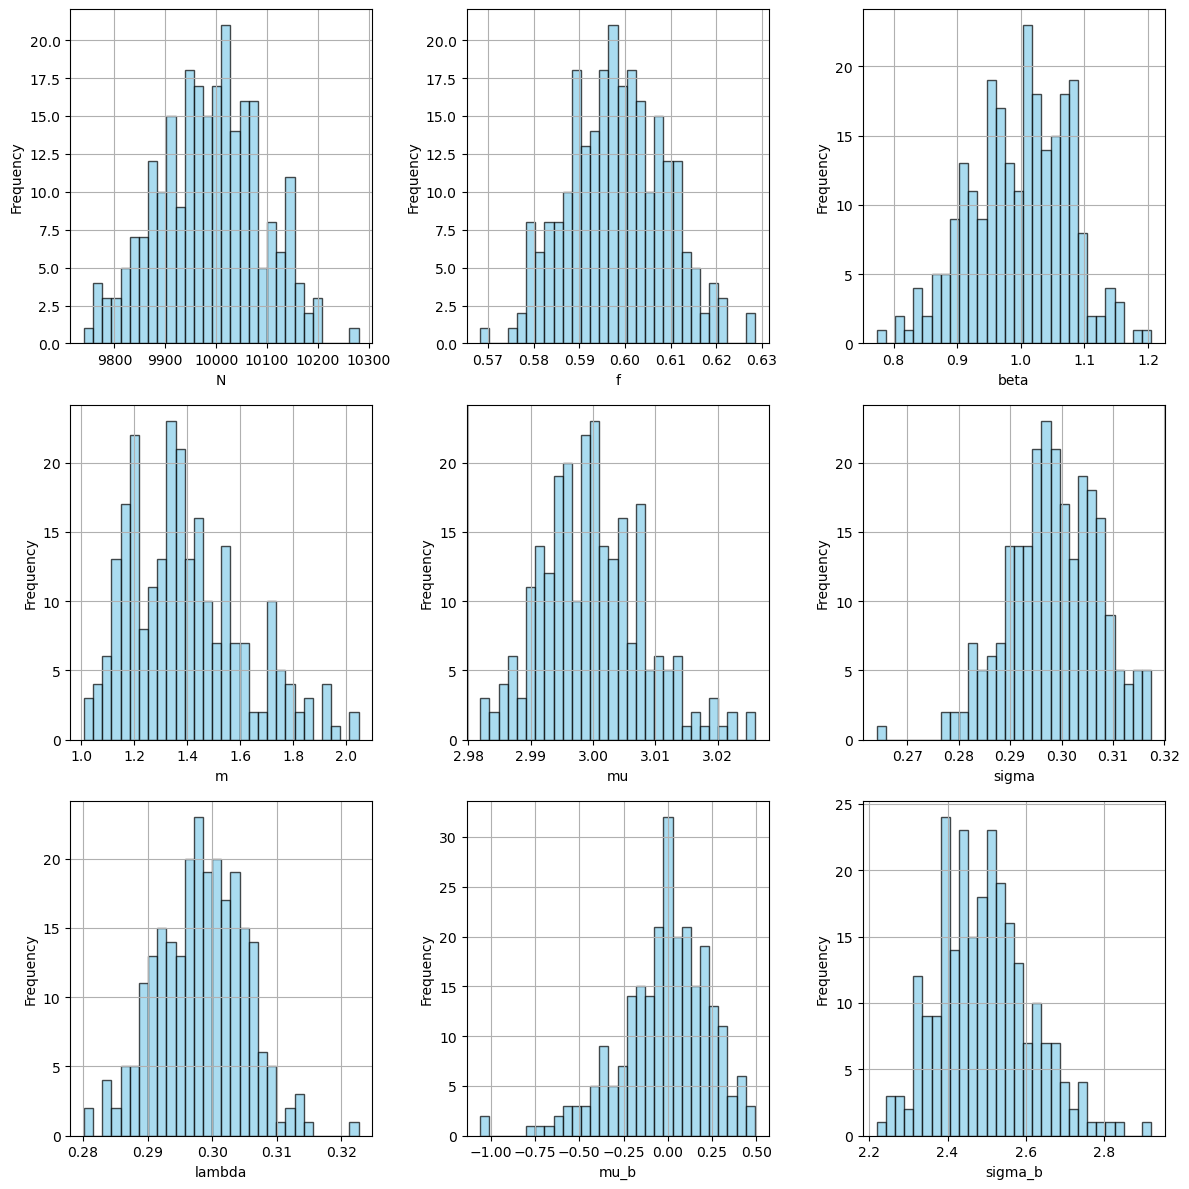

In [221]:

values = np.array(values)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3x3 grid for 9 subplots
Names = ['N', 'f', 'beta', 'm', 'mu', 'sigma', 'lambda', 'mu_b', 'sigma_b']
# Flatten the axes to iterate over them easily
axes = axes.flatten()

# Loop through each column (parameter) in the values array and plot a histogram
for i in range(9):
    axes[i].hist(values[:, i], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
     # Set the title for each subplot
    axes[i].set_xlabel(Names[i])
    axes[i].set_ylabel("Frequency")
    axes[i].grid(True)

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [328]:
import ast  

def extract_values_and_errors(folder_name):
    # List to store extracted data
    extracted_data = []
    
    # Check if the folder exists
    if not os.path.exists(folder_name):
        print(f"Folder '{folder_name}' does not exist.")
        return extracted_data
    
    # Iterate over all files in the folder
    for filename in os.listdir(folder_name):
        if filename.endswith("_values_and_errors.txt"):
            file_path = os.path.join(folder_name, filename)
            with open(file_path, 'r') as file:
                # Read the lines in the file
                lines = file.readlines()
                removed_lines=0
                # Extract sample size (first line)
                sample_size = int(lines[0].split(":")[1].strip())
                
                # Extract values (lines between "Values:" and "Errors:")
                values_start_index = lines.index("Values:\n") + 1
                values_end_index = lines.index("Errors:\n")
                values = ast.literal_eval(''.join(lines[values_start_index:values_end_index]).strip())
                
                # Extract errors (lines after "Errors:")
                errors_str = ''.join(lines[values_end_index + 1:]).strip()
                errors_str = errors_str.replace('nan', '0.00000')
                errors = ast.literal_eval(errors_str)
                
                valid_values = []  
                valid_errors = []  

                for i in range(len(errors)):
                    if any(element == 0.0 for element in errors[i]):
                        removed_lines+=1
                    else:
                        valid_values.append(values[i])
                        valid_errors.append(errors[i])

                print(f"Removed {removed_lines} samples from sample size {sample_size} due to nan errors.")          
                #Store the extracted data
                extracted_data.append({
                    'sample_size': sample_size,
                    'values': valid_values,
                    'errors': valid_errors
                })

    # for data in extracted_data:
    #     sample_size = data['sample_size']
    #     values_length = len(data['values'])
    #     errors_length = len(data['errors'])
    #     print(f"Sample size: {sample_size} | Length of values: {values_length} | Length of errors: {errors_length}")
    
    return extracted_data

def read_lambda_vals(extracted_data):
    element_values={}
    element_errors={}
    for data in extracted_data:
        sample_size = data['sample_size']
        values = data['values']
        errors = data['errors']

        sample_values = []
        sample_errors = []

        for i in range(len(values)):
            sample_values.append(values[i][6])
            sample_errors.append(errors[i][6])

        element_values[f'sample_{sample_size}_lam_values'] = sample_values
        element_errors[f'sample_{sample_size}_lam_errs'] = sample_errors

    return element_values, element_errors


extracted_data = extract_values_and_errors("Parametric_Bootstrapping_Data")

lam_values, lam_errors = read_lambda_vals(extracted_data)

sample_500_lam_values = lam_values.get('sample_500_lam_values', None)
sample_500_lam_errors = lam_errors.get('sample_500_lam_errs', None)

sample_1000_lam_values = lam_values.get('sample_1000_lam_values', None)
sample_1000_lam_errors = lam_errors.get('sample_1000_lam_errs', None)

sample_2500_lam_values = lam_values.get('sample_2500_lam_values', None)
sample_2500_lam_errors = lam_errors.get('sample_2500_lam_errs', None)

sample_5000_lam_values = lam_values.get('sample_5000_lam_values', None)
sample_5000_lam_errors = lam_errors.get('sample_5000_lam_errs', None)

sample_10000_lam_values = lam_values.get('sample_10000_lam_values', None)
sample_10000_lam_errors = lam_errors.get('sample_10000_lam_errs', None)



Removed 9 samples from sample size 1000 due to nan errors.
Removed 3 samples from sample size 5000 due to nan errors.
Removed 9 samples from sample size 500 due to nan errors.
Removed 6 samples from sample size 2500 due to nan errors.
Removed 1 samples from sample size 10000 due to nan errors.


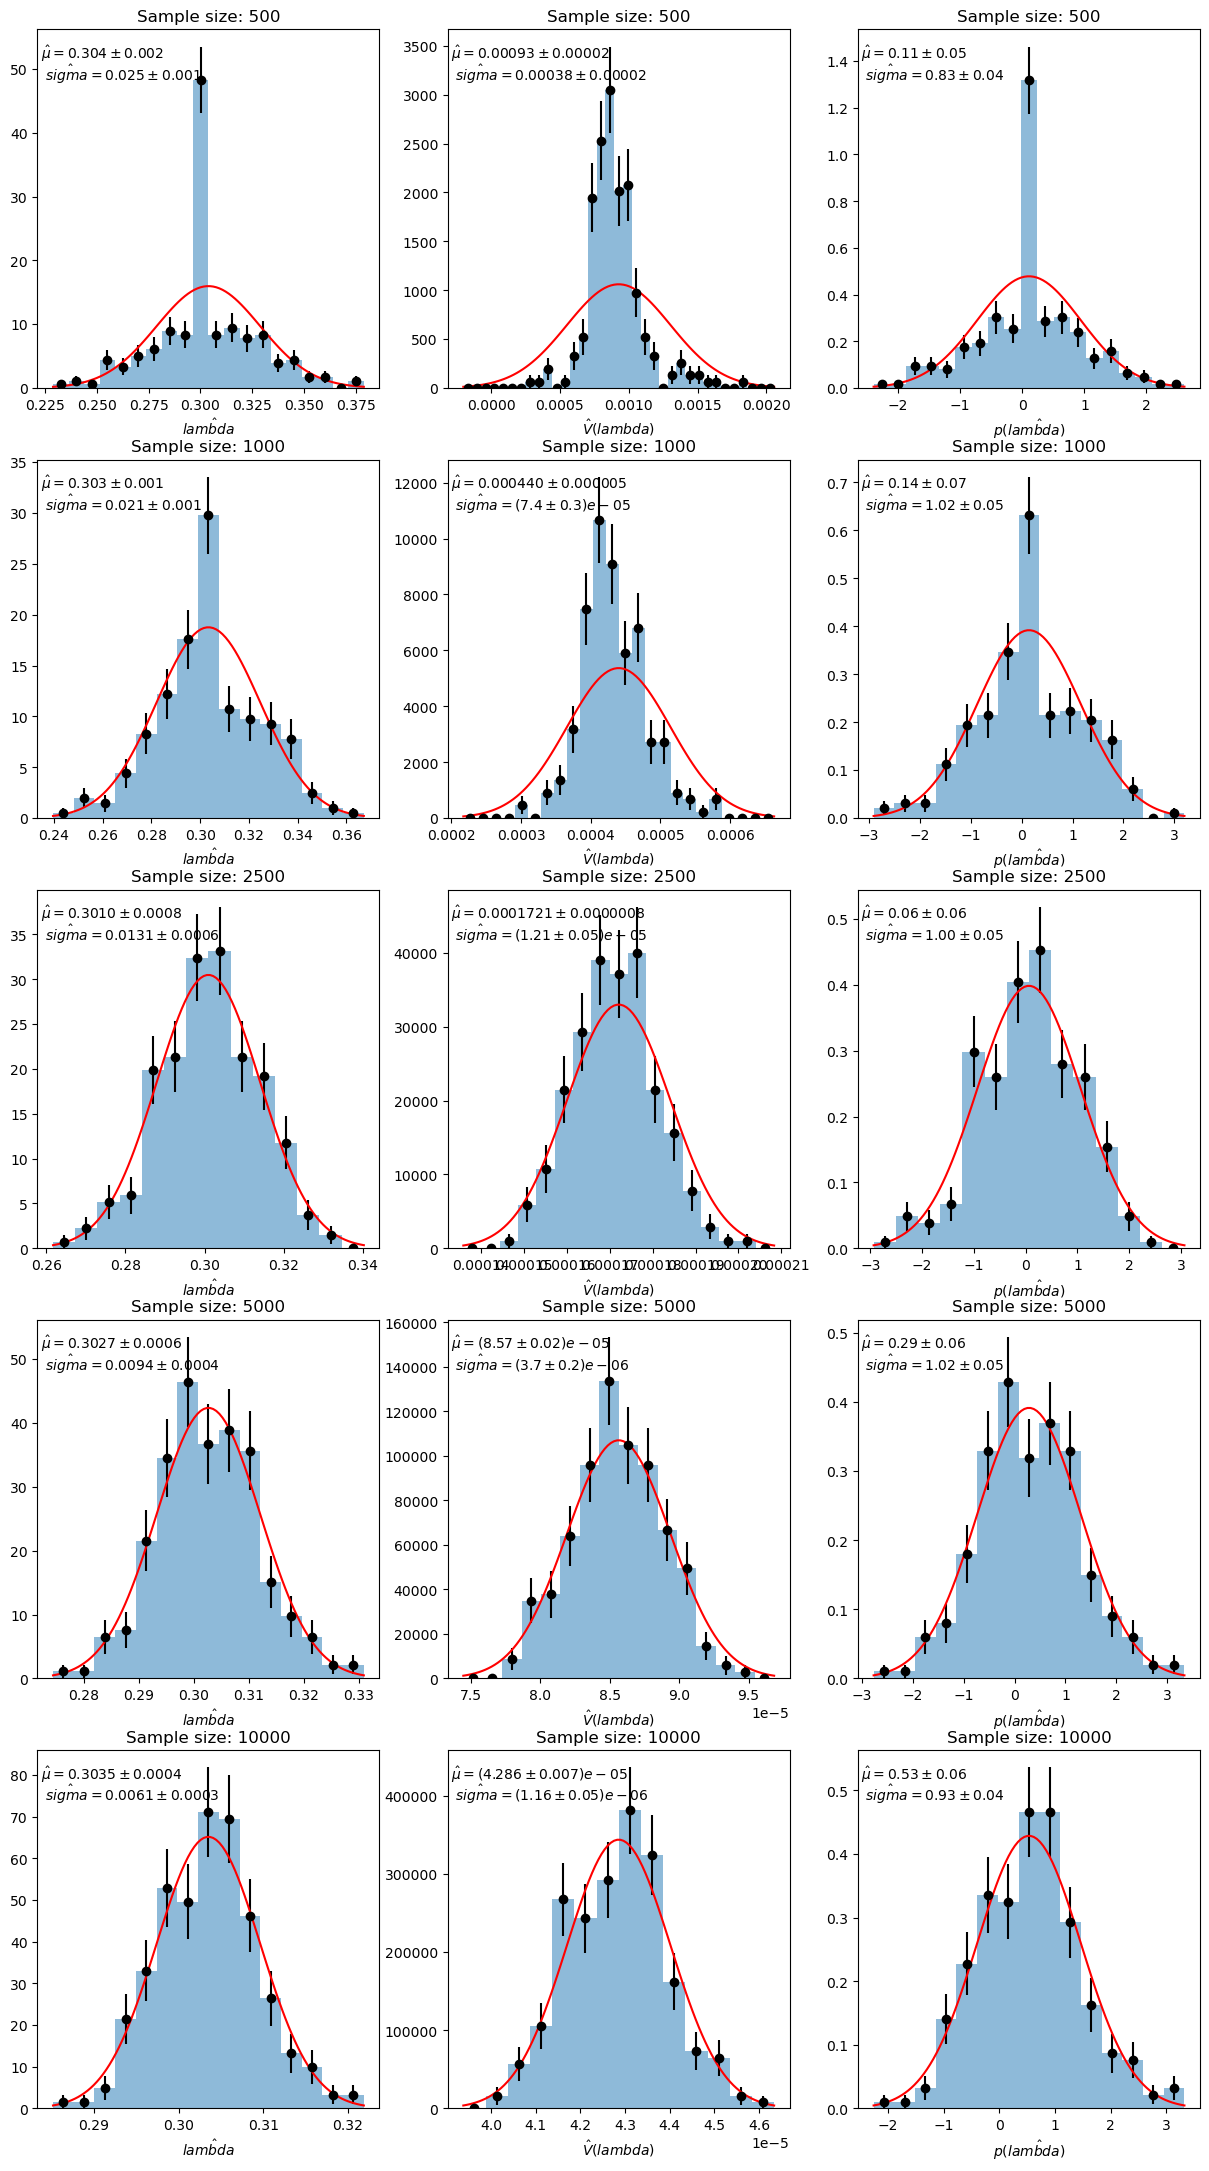

In [344]:
import uncertainties as uncert


def plot(xvals , ax=None):
    ax = ax or plt.gca()
    # compute mean , sdev and their errors of distribution
    m = np.mean(xvals)
    s = np.std(xvals , ddof=1)
    me = s/len(xvals)**0.5
    se = s/(2*len(xvals)-1)**0.5
    # make a density histogram
    nh, xe = np.histogram( xvals , range =(m-3*s,m+3*s), bins='auto', density=True )
    # draw the density histogram
    ax.hist( xvals , bins=xe, density=True , alpha=0.5 )
    # also draw error bars on points
    N = np.sum(nh)/len(xvals)
    cx = 0.5*(xe[1:]+xe[:-1])
    ax.errorbar( cx, nh, N*(nh/N)**0.5, fmt='ko')
    # draw the normal distribution with the mean and sigma
    x = np.linspace(xe[0],xe[-1],100)
    ax.plot(x, norm.pdf(x,m,s), 'r-')
    # plot the results (use uncertainties package for nice formatting)
    um = uncert.ufloat( m, me )
    us = uncert.ufloat( s, se )
    mstr = f"{um:.1u}".replace("+/-","\pm")
    sstr = f"{us:.1u}".replace("+/-","\pm")
    ax.text(0.01,0.92, f"$\hat{{\mu}} = {mstr}$", transform=ax.transAxes)   
    ax.text(0.01,0.86, f"$\hat{{\ sigma}} = {sstr}$", transform=ax.transAxes)


sample_sizes = [500, 1000, 2500, 5000, 10000]
sample_lam_values = {
    500: sample_500_lam_values,    
    1000: sample_1000_lam_values,  
    2500: sample_2500_lam_values,  
    5000: sample_5000_lam_values, 
    10000: sample_10000_lam_values 
}

sample_lam_errors = {
    500: sample_500_lam_errors,    
    1000: sample_1000_lam_errors, 
    2500: sample_2500_lam_errors,  
    5000: sample_5000_lam_errors,  
    10000: sample_10000_lam_errors 
}

fig, axes = plt.subplots(5, 3, figsize=(15, 27))  
for i, sample_size in enumerate(sample_sizes):
    # Get the lam values and errors for this sample size
    values = np.array(sample_lam_values[sample_size])
    errors = np.array(sample_lam_errors[sample_size])
    
    # Calculate the pulls (residuals normalized by errors)
    pulls = (values - lam_true) / errors

    for j, name in enumerate(Names):
        estname = f"\hat {{{ name.split('_ ')[0]}}}"
        if len(name.split('_'))>1: estname += '_'+name.split('_')[1]
        
        ax = axes[i,0]
        plot( values, ax )
        ax.set_xlabel( f"${estname}$" )

        ax = axes[i,1]
        plot( errors**2, ax )
        ax.set_xlabel( f"$\hat{{V}}({ name})$" )

        ax = axes[i,2]
        plot( pulls, ax )
        ax.set_xlabel( f"$p({ estname })$" )

    axes[i, 0].set_title(f"Sample size: {sample_size}")
    axes[i, 1].set_title(f"Sample size: {sample_size}")
    axes[i, 2].set_title(f"Sample size: {sample_size}")





[[1.00317794e+02 1.14832358e-02 7.31365105e-02 ... 6.49501055e-03
  2.21971355e-01 1.05526358e-01]
 [9.96349476e+01 1.13626483e-02 6.01794639e-02 ... 6.52299991e-03
  2.28563955e-01 1.12286753e-01]
 [1.00238626e+02 1.10493957e-02 7.68530607e-02 ... 6.41780107e-03
  2.17934432e-01 1.10066476e-01]
 ...
 [1.00514007e+02 1.09486852e-02 6.70000503e-02 ... 6.55065531e-03
  2.22776407e-01 1.05627255e-01]
 [1.00624385e+02 1.09124276e-02 6.30949489e-02 ... 6.48608725e-03
  2.69832320e-01 1.21385998e-01]
 [9.98566970e+01 1.11226601e-02 7.32897662e-02 ... 6.55432912e-03
  2.47911338e-01 1.16739238e-01]]
